In [120]:
import requests
import pandas as pd
import time

# Defining places
place_types = {
    "Supermarket": 'node["shop"="supermarket"]',
    "Transit Stop": 'node["amenity"="bus_station"];node["railway"="station"]',
    "Square": 'node["place"="square"]',
    "Park": 'node["leisure"="park"]',
    "School": 'node["amenity"="school"]',
    "Parking Lot": 'node["amenity"="parking"]'
}

# Function to get latitude and longitude of places from Overpass API
def get_places(place_type, overpass_queries, city="London"):
    overpass_url = "http://overpass-api.de/api/interpreter"
    queries = overpass_queries.split(';')
    places = []

    for query in queries:
        overpass_query = f"""
        [out:json];
        area[name="{city}"]->.searchArea;
        (
          {query}(area.searchArea);
        );
        out body;
        >;
        out skel qt;
        """

        # Retry loop
        for _ in range(3):  # Retry up to 3 times
            try:
                response = requests.post(overpass_url, data={'data': overpass_query})
                if response.status_code == 200:
                    try:
                        data = response.json()
                        for element in data['elements']:
                            places.append({
                                "Name": element.get("tags", {}).get("name", "N/A"),
                                "Latitude": element.get("lat"),
                                "Longitude": element.get("lon"),
                                "Type": place_type
                            })
                    except ValueError:
                        print(f"Invalid JSON response for {place_type}")
                        continue
                else:
                    print(f"Failed to retrieve data for {place_type}, status code: {response.status_code}")
            except requests.RequestException as e:
                print(f"Request exception for {place_type}: {e}")
            time.sleep(1) 

    return places

# Fetching places for the various types
all_places = []
place_counts = {}
for place_type, overpass_queries in place_types.items():
    places = get_places(place_type, overpass_queries)
    all_places.extend(places)
    place_counts[place_type] = len(places)


loc = pd.DataFrame(all_places)
loc['Loc_ID'] = loc.index

# Saving to csv
csv_file_path = 'loc.csv'
loc.to_csv(csv_file_path, index=False)

print(f"The dataset has been saved to {csv_file_path}")
print("Counts of retrieved places:")
for place_type, count in place_counts.items():
    print(f"{place_type}: {count}")

loc.head()

The dataset has been saved to loc.csv
Counts of retrieved places:
Supermarket: 1917
Transit Stop: 1845
Square: 39
Park: 96
School: 567
Parking Lot: 2064


,Name,Latitude,Longitude,Type,Loc_ID
0,M&S Foodhall,51.537810,-0.142041,Supermarket,0
1,Waitrose,51.516345,-0.187258,Supermarket,1
2,Siragro Food & Wine,51.551496,-0.319722,Supermarket,2
3,Co-op Food,51.365198,-0.161079,Supermarket,3
4,Iceland,51.606668,0.218460,Supermarket,4


In [44]:
sas = pd.read_csv("../data/merged_filtered_sas.csv")

drug_sas = sas[(sas['Object of search'] == 'Controlled drugs') & (sas['Borough'] != 'Unknown')].reset_index(drop=True).drop(columns=["Arrest Year", "quarter", "Removal of more than just outer clothing", "Outcome linked to object of search"])

loc = pd.read_csv("../data/loc.csv")
loc['Loc_ID'] = loc.index

In [45]:
loc

,Name,Latitude,Longitude,Type,Loc_ID
0,M&S Foodhall,51.537810,-0.142041,Supermarket,0
1,Waitrose,51.516345,-0.187258,Supermarket,1
2,Siragro Food & Wine,51.551496,-0.319722,Supermarket,2
3,Co-op Food,51.365198,-0.161079,Supermarket,3
4,Iceland,51.606668,0.218460,Supermarket,4
...,...,...,...,...,...
6523,NaN,51.547782,-0.003717,Parking_lot,6523
6524,NaN,51.539573,-0.460101,Parking_lot,6524
6525,Sainsbury's,51.481226,-0.128222,Parking_lot,6525
6526,Grainges Car Park,51.545411,-0.481504,Parking_lot,6526


In [60]:
type_counts = loc['Type'].value_counts()
print(type_counts)

Type
Parking_lot    2064
Supermarket    1917
Transport      1845
School          567
Park             96
Square           39
Name: count, dtype: int64


In [48]:
import pandas as pd
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians 
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)) 
    r = 6371
    return c * r

# Initialize columns
drug_sas['LocID'] = np.nan
drug_sas['Type'] = np.nan
drug_sas['Distance'] = np.nan

# Find the nearest location for each row in drug_sas
for i, row in drug_sas.iterrows():
    distances = loc.apply(lambda x: haversine(row['Latitude'], row['Longitude'], x['Latitude'], x['Longitude']), axis=1)
    nearest_index = distances.idxmin()
    drug_sas.at[i, 'LocID'] = loc.at[nearest_index, 'Loc_ID']
    drug_sas.at[i, 'Type'] = loc.at[nearest_index, 'Type']
    drug_sas.at[i, 'Distance'] = distances[nearest_index]
    
drug_sas.to_csv('../data/drug_sas_loc.csv', index=False)

C:\Users\Work\AppData\Local\Temp\ipykernel_17064\1825270470.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Supermarket' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  drug_sas.at[i, 'Type'] = loc.at[nearest_index, 'Type']


In [117]:
drug_sas_loc = pd.read_csv("../data/drug_sas_loc.csv")
drug_sas_loc

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Borough,LocID,Distance
0,Supermarket,2021-03-31 23:01:00+00:00,False,NaN,51.500886,-0.068284,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Southwark,242.0,0.331902
1,Parking Lot,2021-04-01 08:50:00+00:00,False,NaN,51.493521,-0.100216,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,Southwark,4992.0,0.103082
2,Transit Stop,2021-04-01 08:55:00+00:00,False,NaN,51.576002,0.183438,Male,10-17,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Havering,2001.0,0.174198
3,Transit Stop,2021-04-01 08:55:00+00:00,False,NaN,51.576002,0.183438,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Havering,2001.0,0.174198
4,Transit Stop,2021-04-01 08:56:00+00:00,False,NaN,51.576002,0.183438,Male,10-17,Asian/Asian British - Indian,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Havering,2001.0,0.174198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17233,Transit Stop,2023-09-30 19:30:00+00:00,False,NaN,51.507779,-0.264173,Male,10-17,White - Any other White background,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,Ealing,2060.0,0.140706
17234,School,2023-09-30 21:15:00+00:00,False,NaN,51.513498,-0.130169,Female,10-17,Mixed/Multiple ethnic groups - White and Black...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,Islington,4020.0,0.023910
17235,Parking Lot,2023-09-30 21:15:00+00:00,False,NaN,51.512270,0.010902,Male,10-17,Asian/Asian British - Bangladeshi,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,Newham,5063.0,0.241199
17236,Transit Stop,2023-09-30 21:39:00+00:00,False,NaN,51.507779,-0.264173,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Ealing,2060.0,0.140706


In [118]:
drug_sas_loc = pd.read_csv("../data/drug_sas_loc.csv")
drug_sas_loc= drug_sas_loc[drug_sas_loc['Distance'] <= 0.3]
drug_sas_loc

,Type,Date,Part of a policing operation,Policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Borough,LocID,Distance
1,Parking Lot,2021-04-01 08:50:00+00:00,False,NaN,51.493521,-0.100216,Male,10-17,Other ethnic group - Not stated,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Arrest,Southwark,4992.0,0.103082
2,Transit Stop,2021-04-01 08:55:00+00:00,False,NaN,51.576002,0.183438,Male,10-17,Asian/Asian British - Any other Asian background,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Havering,2001.0,0.174198
3,Transit Stop,2021-04-01 08:55:00+00:00,False,NaN,51.576002,0.183438,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Havering,2001.0,0.174198
4,Transit Stop,2021-04-01 08:56:00+00:00,False,NaN,51.576002,0.183438,Male,10-17,Asian/Asian British - Indian,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Havering,2001.0,0.174198
6,Supermarket,2021-04-01 12:50:00+00:00,False,NaN,51.476083,-0.070988,Male,10-17,Mixed/Multiple ethnic groups - Any other Mixed...,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Southwark,362.0,0.289002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17233,Transit Stop,2023-09-30 19:30:00+00:00,False,NaN,51.507779,-0.264173,Male,10-17,White - Any other White background,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,Ealing,2060.0,0.140706
17234,School,2023-09-30 21:15:00+00:00,False,NaN,51.513498,-0.130169,Female,10-17,Mixed/Multiple ethnic groups - White and Black...,Black,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,Islington,4020.0,0.023910
17235,Parking Lot,2023-09-30 21:15:00+00:00,False,NaN,51.512270,0.010902,Male,10-17,Asian/Asian British - Bangladeshi,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,Community resolution,Newham,5063.0,0.241199
17236,Transit Stop,2023-09-30 21:39:00+00:00,False,NaN,51.507779,-0.264173,Male,10-17,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,Ealing,2060.0,0.140706


Type
Transit Stop    3572
Supermarket     2582
Parking Lot     2368
School           628
Park              90
Square            49
Name: count, dtype: int64


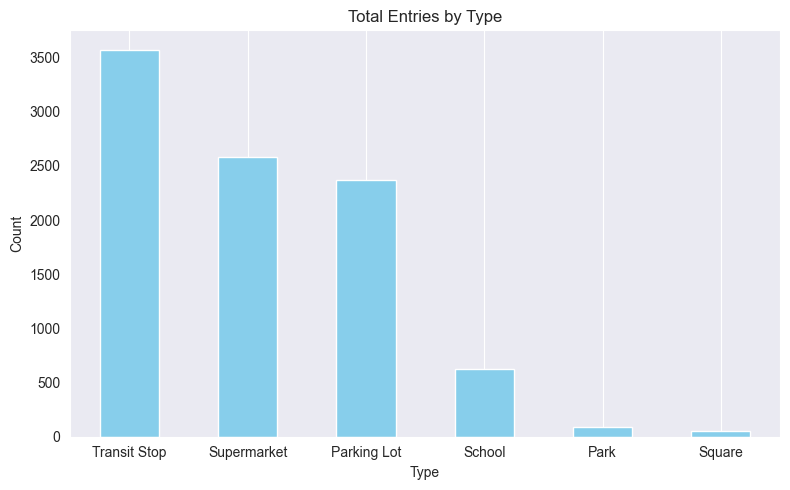

In [121]:
import matplotlib.pyplot as plt

type_counts = drug_sas_loc['Type'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color='skyblue')
plt.title('Total Entries by Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
print(type_counts)
plt.show()

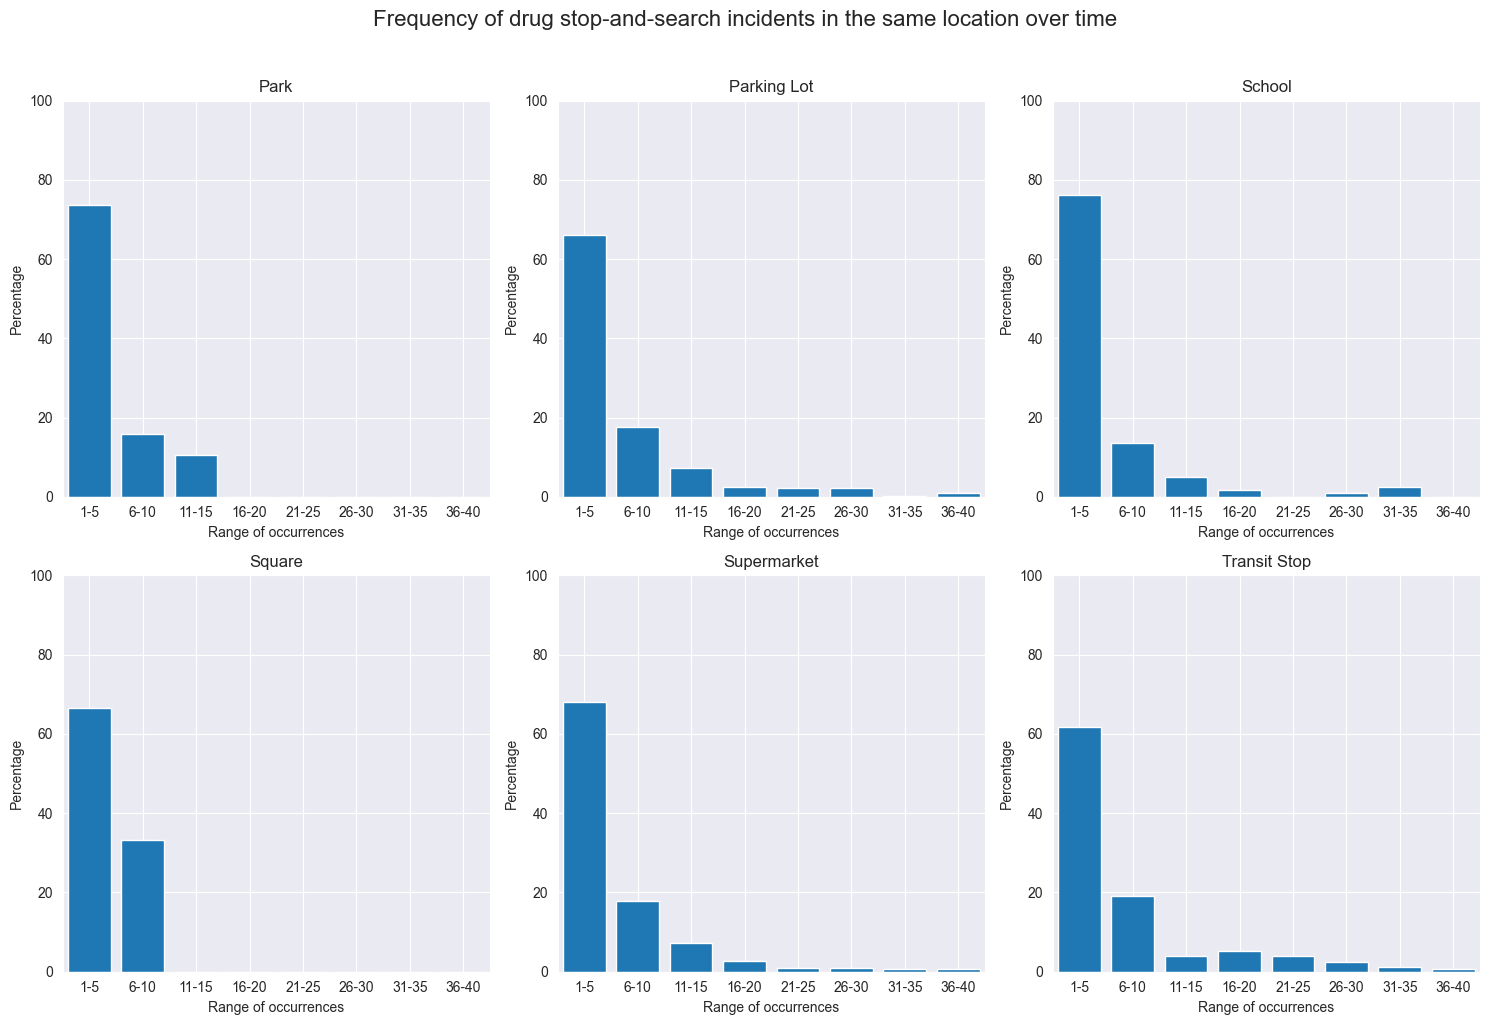

In [126]:
drug_sas_loc_unique = drug_sas_loc.drop_duplicates(subset=['LocID', 'Date'])

# Count occurrences of each (LocID, Type) combination
locid_type_counts = drug_sas_loc_unique.groupby(['Type', 'LocID']).size().reset_index(name='Repeat_Sas_count')

# Count how many LocID values appear a certain number of times for each Type
type_repeat_counts = locid_type_counts.groupby(['Type', 'Repeat_Sas_count']).size().reset_index(name='Count')

# Define ranges for stacked bar chart segments
ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 25), (26, 30), (31, 35), (36, 40)]

# Initialize figure and axis
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Frequency of drug stop-and-search incidents in the same location over time', y=1.02, fontsize=16)

# Iterate over each Type and subplot
for idx, (type_name, group) in enumerate(type_repeat_counts.groupby('Type')):
    ax = axs[idx // 3, idx % 3]

    # Initialize counts for each range
    counts = [0] * len(ranges)
    total_count = group['Count'].sum()
    for i, r in enumerate(ranges):
        counts[i] = group[group['Repeat_Sas_count'].between(r[0], r[1])]['Count'].sum() / total_count * 100
        
    ax.bar(range(len(ranges)), counts, tick_label=[f'{r[0]}-{r[1]}' for r in ranges])
    ax.set_title(f'{type_name}', fontsize=12)
    ax.set_xlabel('Range of occurrences')
    ax.set_ylabel('Percentage')

    # Set individual x-axis and y-axis for each plot
    ax.set_xlim(-0.5, len(ranges) - 0.5)
    ax.set_ylim(0, 100)  # Fixed y-axis from 0 to 100 for percentage

# Adjust layout and display
plt.tight_layout()
plt.show()

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Date' from string to datetime
drug_sas_loc['Date'] = pd.to_datetime(drug_sas_loc['Date'])

# Extract hour and categorize into time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

drug_sas_loc['TimeOfDay'] = drug_sas_loc['Date'].dt.hour.apply(categorize_time_of_day)


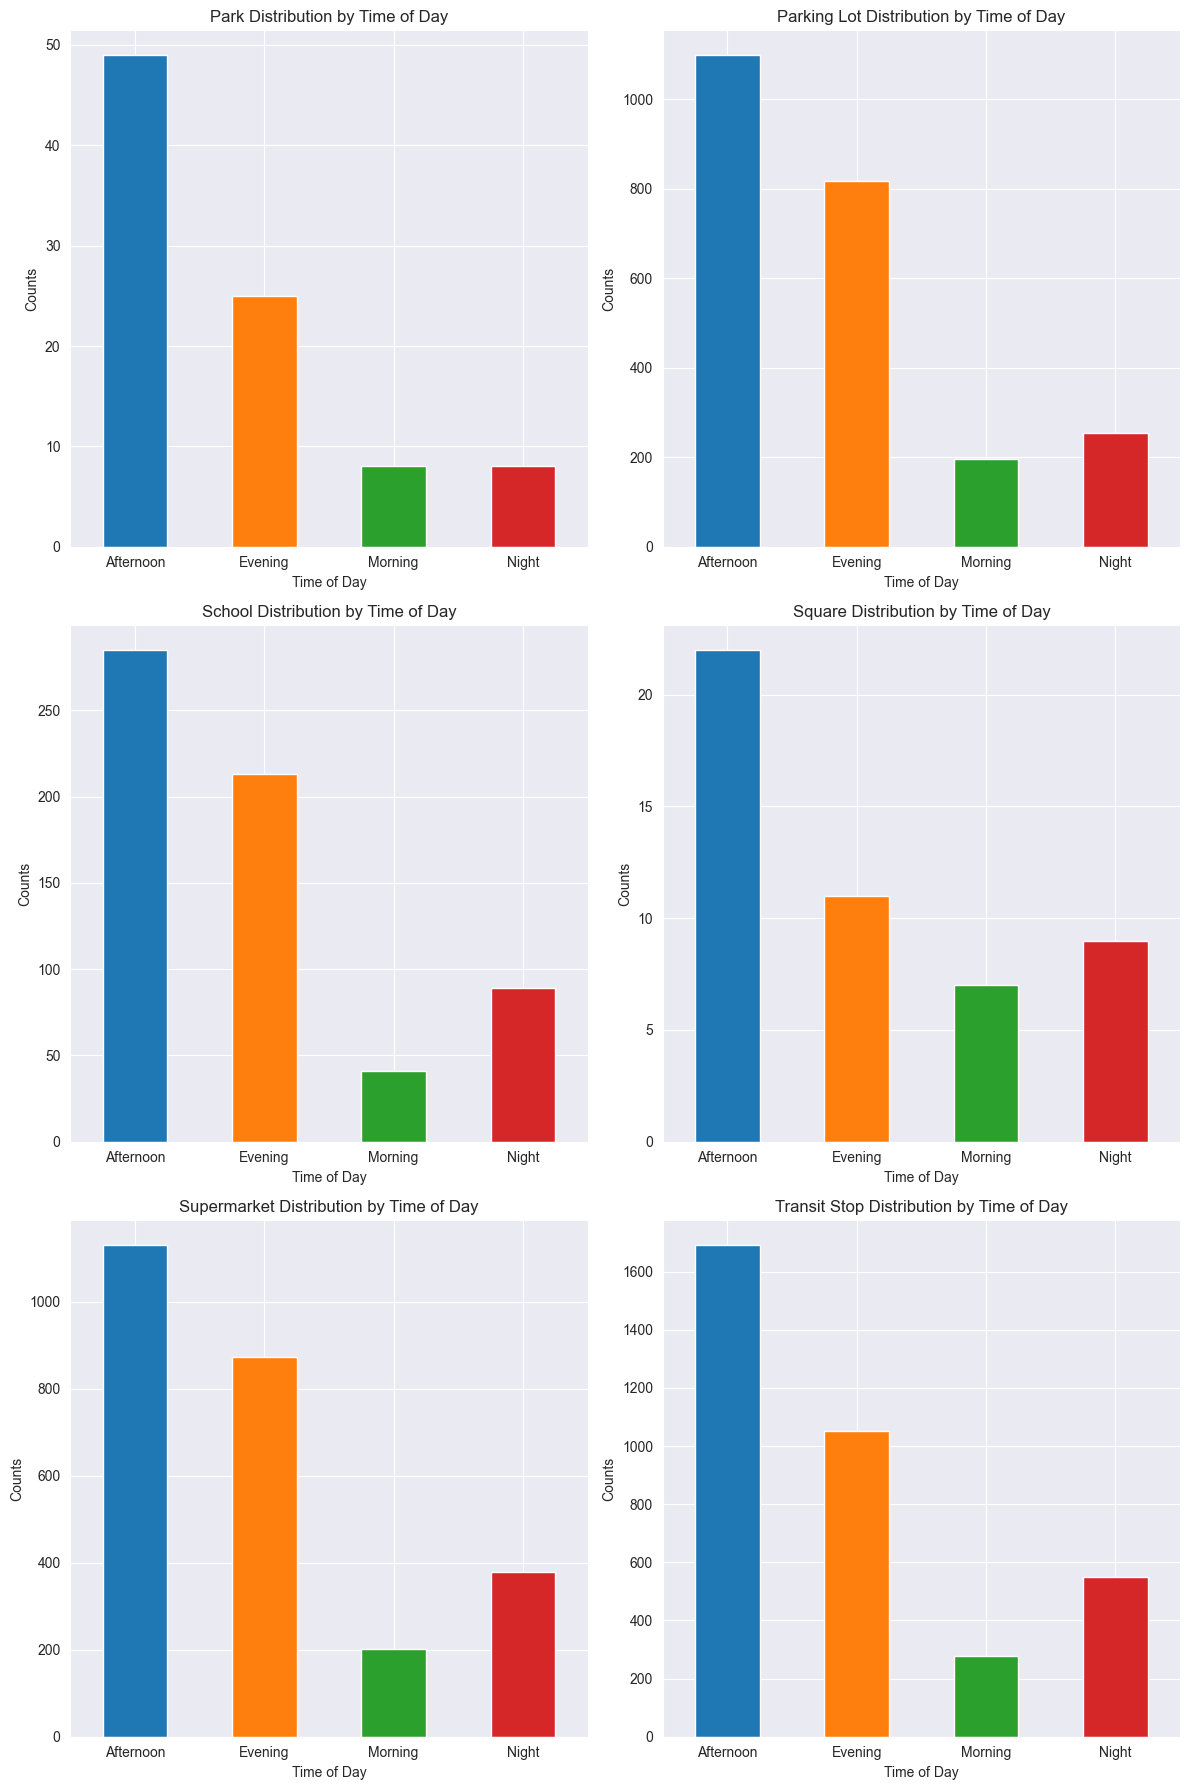

In [132]:
# Group by Type and TimeOfDay, then count occurrences
type_time_counts = drug_sas_loc.groupby(['Type', 'TimeOfDay']).size().unstack(fill_value=0)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 18)) 
axs = axs.flatten()  

# Plot each Type in a separate subplot
for idx, (type_name, counts) in enumerate(type_time_counts.iterrows()):
    ax = axs[idx]
    counts.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])  # Colors for Morning, Afternoon, Evening, Night
    ax.set_title(f'{type_name} Distribution by Time of Day')
    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Counts')
    ax.set_xticklabels(counts.index, rotation=0)

plt.tight_layout()
plt.show()